In [10]:
import pandas as pd
import os

REPO_DIR = os.path.join(os.getcwd(), "../../")


### How many TRACERx NSCLC tumors have multi-region sampling?


In [11]:

sample_info_df = pd.read_csv(os.path.join(REPO_DIR, "data/tracerx_nsclc/","sample_overview_original.txt"), sep="\t")
print(sample_info_df.head())

multi_region_sample_ct = 0
for pid in sample_info_df['patient_id'].unique():
    patient_samples = list(sample_info_df[sample_info_df['patient_id']==pid]['region'])
    sample_types = list(sample_info_df[sample_info_df['patient_id']==pid]['sampleType'])
    if sample_types.count("primary") > 1:
        multi_region_sample_ct += 1
    else:
        print(pid, patient_samples, sample_types)
multi_region_sample_ct

  patient_id tumour_id             region  sampleType sampleTypeDetail
0   CRUK0010  CRUK0010  CRUK0010_SU_T1.R1     primary          primary
1   CRUK0010  CRUK0010  CRUK0010_SU_T1.R2     primary          primary
2   CRUK0010  CRUK0010   CRUK0010_SU_FLN1  metastasis               LN
3   CRUK0010  CRUK0010    CRUK0010_BR_LN1  metastasis  metachronousMet
4   CRUK0010  CRUK0010    CRUK0010_BR_LN2  metastasis  metachronousMet
CRUK0721 ['CRUK0721_SU_T1.R1', 'CRUK0721_SU_FLN1'] ['primary', 'metastasis']
CRUK0227 ['CRUK0227_SU_T1.R2', 'CRUK0227_SU_FLN1'] ['primary', 'metastasis']
CRUK0089 ['CRUK0089_SU_T1.R2', 'CRUK0089_SU_FLN1'] ['primary', 'metastasis']
CRUK0301 ['CRUK0301_SU_T1.R1', 'CRUK0301_SU_FLN1'] ['primary', 'metastasis']
CRUK0325 ['CRUK0325_SU_T1.R2', 'CRUK0325_BR_T1.FR1', 'CRUK0325_SU_FLN1'] ['primary', 'metastasis', 'metastasis']
CRUK0467 ['CRUK0467_SU_T1.R2', 'CRUK0467_SU_FLN1', 'CRUK0467_BP_T1.R1', 'CRUK0467_BR_T1.R1'] ['primary', 'metastasis', 'metastasis', 'metastasis']
CRUK05

119

### How many mcpherson ovarian samples have multi-region sampling?

In [26]:
samples_df = pd.read_csv(os.path.join(REPO_DIR, 'data', 'mcpherson_ovarian_2016', 'supplemental_table_1.csv'))
multi_region_sample_ct = 0
for pid in samples_df['patient_id'].unique():
    patient_samples = list(samples_df[samples_df['patient_id']==pid]['sample_id'])
    print((patient_samples))
    seen_basenames = set()
    for samp in patient_samples:
        if samp[-1].isdigit():
            basename = "_".join(samp.split("_")[:-1])
            if basename in seen_basenames:
                continue
            is_substring = [1 if basename in x else 0 for x in patient_samples] 
            if sum(is_substring) > 1:
                multi_region_sample_ct += 1
            seen_basenames.add(basename)
            
multi_region_sample_ct
        

['normal_blood', 'appendix_site_c1', 'left_fallopian_tube_site_b4', 'left_ovary_site_b2', 'right_fallopian_tube_site_a16', 'right_ovary_site_a4', 'small_bowel_site_e4', 'omentum_site_1', 'right_ovary_site_1', 'right_ovary_site_2', 'right_ovary_site_3', 'right_ovary_site_4', 'small_bowel_site_1']
['normal_blood', 'left_ovary_site_d3', 'omentum_site_a2', 'omentum_site_b1', 'right_fallopian_tube_site_c10', 'right_ovary_site_c2', 'right_ovary_site_c4', 'omentum_site_1', 'omentum_site_2', 'right_ovary_site_1', 'right_ovary_site_2']
['normal_blood', 'cul_de_sac_site_b1', 'sigmoid_colon_deposit_site_e1', 'left_fallopian_tube_fimbriae_site_c1', 'left_ovary_site_c5', 'omentum_site_f2', 'right_fallopian_tube_site_a2', 'right_ovary_site_a7', 'adnexa_site_1', 'omentum_site_1', 'right_ovary_site_1', 'right_ovary_site_2']
['normal_blood', 'left_ovary_surface_site_b2', 'left_pelvic_sidewall_site_c1', 'right_ovary_site_a5', 'right_pelvic_sidewall_site_d1', 'left_pelvic_sidewall_site_1', 'right_ovary_s

14

### How many neuroblastoma samples have multi-region sequencing?

In [32]:
10

10

HGSOC


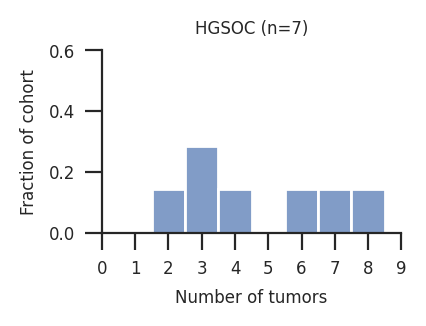

Melanoma


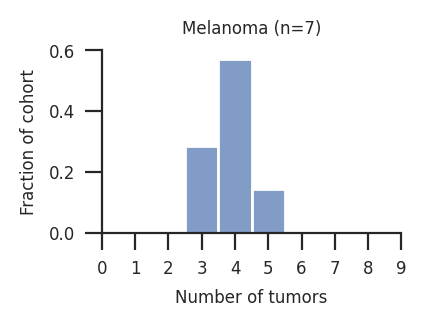

HR-NB


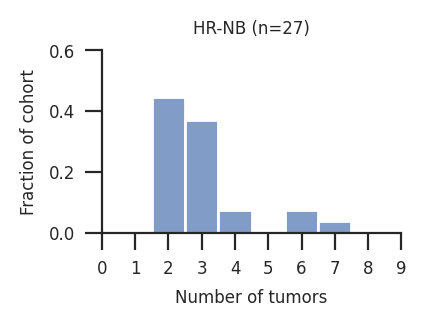

NSCLC


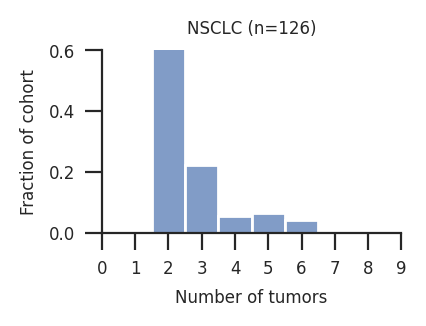

In [68]:
import glob
import gzip
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from metient.util.globals import *

DATASET_NAMES = [ "HGSOC", "Melanoma", "HR-NB", "NSCLC"]
CALIBRATE_DIRS = [os.path.join(REPO_DIR,"data/mcpherson_ovarian_2016/metient_outputs/solve_polys", "calibrate"),
                  os.path.join(REPO_DIR,"data/sanborn_melanoma_2015/metient_outputs_solve_polys_no_cna_pyclone_vi_orchard", "calibrate"),
                  os.path.join(REPO_DIR,"data/gundem_neuroblastoma_2023/metient_outputs/solve_polys", "calibrate"),
                  os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/tracerx_trees_06062024/calibrate",)]

# Make a dataframe of the number of mets for each patient        
data = []
dataset_to_pids = {d:set() for d in DATASET_NAMES}
for dataset_name, calibrate_dir in zip(DATASET_NAMES, CALIBRATE_DIRS):
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    for fn in matching_files:
        pid = fn.split("/")[-1].split("_")[0]
        if pid in dataset_to_pids[dataset_name]:
            continue
        with gzip.open(fn, 'rb') as f:
            pkl = pickle.load(f)
            num_sites = len(pkl[OUT_SITES_KEY])
            data.append([dataset_name, num_sites, pid])
            dataset_to_pids[dataset_name].add(pid)
            
df = pd.DataFrame(data, columns=["Cancer type", "Number of tumors", "Patient ID"])

for dataset in DATASET_NAMES:
    sns.set(style='ticks', rc={'axes.labelsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6, 'xtick.major.width': 0.8, 'ytick.major.width': 0.8, 'axes.linewidth': 0.8, })
    fig = plt.figure(figsize=(2,1.5), dpi=200)
    bin_edges = np.arange(0.5, 10.5, 1)
    
    print(dataset)

    ax = sns.histplot(data=df[df['Cancer type']==dataset], x='Number of tumors', legend=False,
                     stat="probability", hue='Cancer type', alpha=0.7, color="#808285", bins=bin_edges,
                     )
    ax.set_xlim(0,8)
    ax.set_ylim(0,0.6)
    plt.xticks(ticks=[x for x in range(0,10)])
    plt.xlabel('Number of tumors')
    plt.ylabel('Fraction of cohort')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(f"{dataset} (n={len(df[df['Cancer type']==dataset])})", fontsize=6)
    plt.setp(ax.collections, alpha=0.7)
    plt.tight_layout(pad=0.2) 
    plt.savefig(f"../output_plots/{dataset}_num_sites_histogram.png")
    plt.show()
    plt.close()
            